# Training of EEG🧠Schizophrenia Disorder using CNN
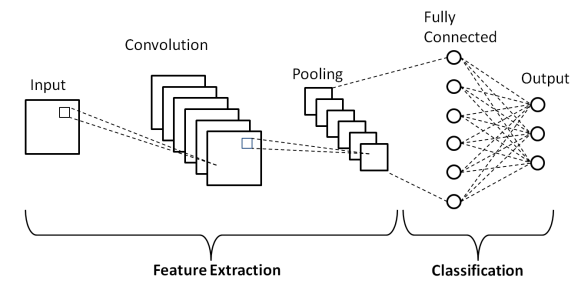

## Goal
The goal of this Notebook is to develop a model to `Classify` individual Patient EEG Signals using `Convolutional Neural Networks`.

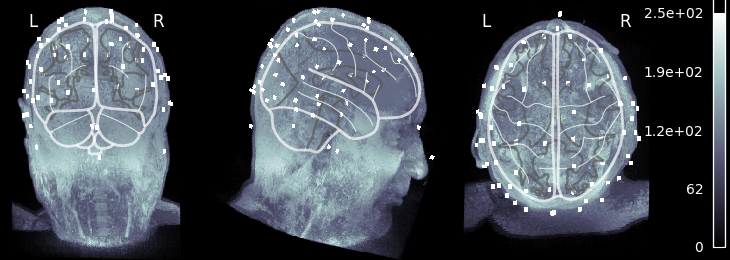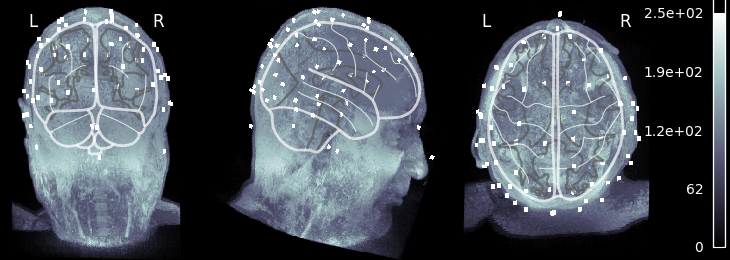

## Data Context
The Notebook contains `EEG Signals` from 80+ Patients, each with multiple trial data. The training signals are stored in two folders named **`../input/button-tone-sz`** and **`../input/buttontonesz2`**.

> Animals and humans have the ability to reduce or suppress the response of their brains to sensory consequences caused by their own actions. This is done through a corollary discharge forward model system, in which an "efference copy" of an upcoming motor plan is transmitted from the motor to sensory cortex. This generates a "corollary discharge" representation of the expected sensory outcomes of the motor act, allowing the brain to differentiate between internally and externally generated stimuli. People with schizophrenia may have difficulty differentiating between internally and externally generated stimuli due to problems with this process. Understanding this process and its relationship to symptoms of schizophrenia may help us better understand abnormal brain processes in these patients.

> In a previous **EEG experiment**, a simple button pressing task was used to study the corollary discharge in people with schizophrenia and comparison controls. The experiment involved subjects either pressing a button to generate a tone, passively listening to the same tone, or pressing a button without generating a tone. Comparison controls were able to suppress the N100, a negative deflection in EEG brain waves 100 milliseconds after the onset of a sound, when they pressed a button to generate a tone compared to passive playback. However, patients with schizophrenia were not able to do so. This data set is a larger sample replication of that previous study and includes EEG data from 22 controls and 36 patients with schizophrenia, as well as 10 controls and 13 patients from the previous report.

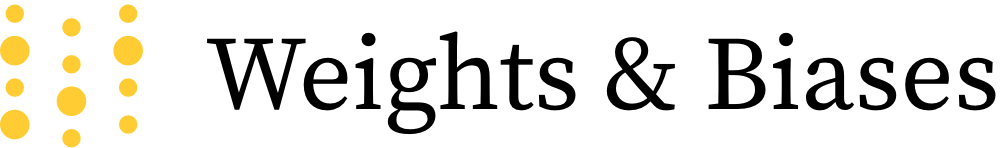

> I will be integrating W&B for visualizations and logging artifacts and comparisons of different models!

In [1]:
import wandb
from wandb.keras import WandbCallback
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api")
wandb.login(key=wandb_api_key)
    
wandb.init(project="Training of EEG Schizophrenia Disorder using CNN",name=f"15. Training-of-EEG-Schizophrenia-Disorder-Run-15")

wandb: Currently logged in as: reverb. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Libraries Imports

In [2]:
import os
import time
import numpy as np
import pandas as pd

import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense
     
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization

from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
! for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

tee: '/sys/bus/pci/devices/0000:00:00.0/numa_node': Read-only file system
0
tee: '/sys/bus/pci/devices/0000:00:01.0/numa_node': Read-only file system
0
tee: '/sys/bus/pci/devices/0000:00:01.3/numa_node': Read-only file system
0
tee: '/sys/bus/pci/devices/0000:00:03.0/numa_node': Read-only file system
0
tee: '/sys/bus/pci/devices/0000:00:04.0/numa_node': Read-only file system
0
tee: '/sys/bus/pci/devices/0000:00:05.0/numa_node': Read-only file system
0
tee: '/sys/bus/pci/devices/0000:00:06.0/numa_node': Read-only file system
0
tee: '/sys/bus/pci/devices/0000:00:07.0/numa_node': Read-only file system
0


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/button-tone-sz/columnLabels.csv
/kaggle/input/button-tone-sz/ERPdata.csv
/kaggle/input/button-tone-sz/demographic.csv
/kaggle/input/button-tone-sz/time.csv
/kaggle/input/button-tone-sz/mergedTrialData.csv
/kaggle/input/button-tone-sz/18.csv/18.csv
/kaggle/input/button-tone-sz/20.csv/20.csv
/kaggle/input/button-tone-sz/71.csv/71.csv
/kaggle/input/button-tone-sz/74.csv/74.csv
/kaggle/input/button-tone-sz/1.csv/1.csv
/kaggle/input/button-tone-sz/24.csv/24.csv
/kaggle/input/button-tone-sz/78.csv/78.csv
/kaggle/input/button-tone-sz/75.csv/75.csv
/kaggle/input/button-tone-sz/11.csv/11.csv
/kaggle/input/button-tone-sz/17.csv/17.csv
/kaggle/input/button-tone-sz/77.csv/77.csv
/kaggle/input/button-tone-sz/16.csv/16.csv
/kaggle/input/button-tone-sz/68.csv/68.csv
/kaggle/input/button-tone-sz/3.csv/3.csv
/kaggle/input/button-tone-sz/19.csv/19.csv
/kaggle/input/button-tone-sz/73.csv/73.csv
/kaggle/input/button-tone-sz/5.csv/5.csv
/kaggle/input/button-tone-sz/2.csv/2.csv
/kaggle/input/b

In [4]:
demographic = pd.read_csv("/kaggle/input/button-tone-sz/demographic.csv")
demographic

,subject,group,gender,age,education
0,1,0,M,44,16.0
1,2,0,M,39,17.0
2,3,0,M,53,18.0
3,4,0,M,52,15.0
4,5,0,M,41,16.0
...,...,...,...,...,...
76,77,1,M,28,13.0
77,78,1,F,32,16.0
78,79,1,M,37,16.0
79,80,1,M,33,13.0


In [5]:
demographic[" group"].value_counts()

1    49
0    32
Name:  group, dtype: int64

In [6]:
demographic[" group"].mean()

0.6049382716049383

In [7]:
for i, t in enumerate(list(demographic[" group"])):
    if t:
        print(f"{i} - Schizophrenia")
    else:
        print(f"{i} - HEALTHY")

0 - HEALTHY
1 - HEALTHY
2 - HEALTHY
3 - HEALTHY
4 - HEALTHY
5 - HEALTHY
6 - HEALTHY
7 - HEALTHY
8 - HEALTHY
9 - HEALTHY
10 - HEALTHY
11 - HEALTHY
12 - HEALTHY
13 - HEALTHY
14 - HEALTHY
15 - HEALTHY
16 - HEALTHY
17 - HEALTHY
18 - HEALTHY
19 - HEALTHY
20 - HEALTHY
21 - HEALTHY
22 - HEALTHY
23 - HEALTHY
24 - Schizophrenia
25 - Schizophrenia
26 - Schizophrenia
27 - Schizophrenia
28 - Schizophrenia
29 - Schizophrenia
30 - Schizophrenia
31 - Schizophrenia
32 - Schizophrenia
33 - Schizophrenia
34 - Schizophrenia
35 - Schizophrenia
36 - Schizophrenia
37 - Schizophrenia
38 - Schizophrenia
39 - Schizophrenia
40 - Schizophrenia
41 - Schizophrenia
42 - Schizophrenia
43 - Schizophrenia
44 - Schizophrenia
45 - Schizophrenia
46 - Schizophrenia
47 - Schizophrenia
48 - Schizophrenia
49 - Schizophrenia
50 - Schizophrenia
51 - Schizophrenia
52 - Schizophrenia
53 - Schizophrenia
54 - Schizophrenia
55 - Schizophrenia
56 - Schizophrenia
57 - Schizophrenia
58 - HEALTHY
59 - HEALTHY
60 - HEALTHY
61 - HEALTHY


In [8]:
diagnosis_dict = dict(zip(demographic.subject, demographic[" group"]))
del demographic #deeting demographic Variable

In [9]:
electrodes_list = list(pd.read_csv("/kaggle/input/button-tone-sz/columnLabels.csv").columns[4:])
print("Electrodes List \n",electrodes_list)

Electrodes List 
 ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'VEOa', 'VEOb', 'HEOL', 'HEOR', 'Nose', 'TP10']


## Data Preprocessing

In [10]:
def averaged_by_N_rows(a, n):
    """ 
    A function that averages n rows in a matrix
    """
    shape = a.shape
    assert len(shape) == 2
    assert shape[0] % n == 0
    b = a.reshape(shape[0] // n, n, 
                  shape[1])
    mean_vec = b.mean(axis=1)
    return mean_vec

In [11]:
N_AVERAGED = 16
x_counter = 0
X = np.zeros((81 * 100,  9216 * len(electrodes_list) // N_AVERAGED), dtype="float32")
Y = np.zeros(len(X))

part1_path = "../input/button-tone-sz"
part2_path = "../input/buttontonesz2"


column_list = pd.read_csv("/kaggle/input/button-tone-sz/columnLabels.csv").columns
for person_number in tqdm(range(1, 81 + 1)):


    csv_path = f"{part1_path}/{person_number}.csv/{person_number}.csv"
    if not os.path.exists(csv_path):
        csv_path = f"{part2_path}/{person_number}.csv/{person_number}.csv"
    df = pd.read_csv(csv_path, 
                header=None,
                names=column_list)
    trials_list = set(df.trial)


    for t1, trial_number in enumerate(trials_list):
        number_of_trials = len(df[df.trial == trial_number])
        if number_of_trials == 9216.0:
            current_sample_matrix = df[df.trial == trial_number][electrodes_list].values
            averaged_by_N = averaged_by_N_rows(current_sample_matrix, n=N_AVERAGED)
            averaged_by_N_big_vec = averaged_by_N.reshape(-1)
            X[x_counter] = averaged_by_N_big_vec.astype(np.float32)
            Y[x_counter] = diagnosis_dict[person_number]
            x_counter += 1
print("Total trials with the Appropriate number of measurements - ", x_counter)
X = X[: x_counter]
Y = Y[: x_counter]
        
print("Total trials with the Appropriate number of measurements- ", x_counter)

  0%|          | 0/81 [00:00<?, ?it/s]

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
   

Total trials with the Appropriate number of measurements -  7092
Total trials with the Appropriate number of measurements-  7092


In [12]:
X.shape

(7092, 40320)

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/disk.py", line 76, in start
    self.metrics_monitor.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'



In [13]:
Y.shape

(7092,)

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/gpu.py", line 355, in start
    self.metrics_monitor.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'



In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

In [15]:
X_norm = (normalize(X.reshape(-1, 70), axis=0, norm='max')).reshape(X.shape)

In [16]:
X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(X_norm, Y, test_size=0.2, shuffle=True, random_state=42)

In [17]:
_norm = X

In [18]:
X_train_2d = X_train_norm.reshape(X_train_norm.shape[0], len(electrodes_list), X_train_norm.shape[1] // len(electrodes_list), 1)
X_test_2d = X_test_norm.reshape(X_test_norm.shape[0], len(electrodes_list), X_test_norm.shape[1] // len(electrodes_list), 1)

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
   

In [19]:
filepath="/kaggle/working/model_1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 20),
                 activation='tanh',
                 input_shape=(X_train_2d.shape[1:])))
model.add(MaxPooling2D(pool_size=(5, 15)))
model.add(Conv2D(13, kernel_size=(3, 3),
                 activation='tanh',))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(317, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.optimizers.Adam(0.0000075),
              metrics=['acc'])

In [21]:
history_params = []

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'



### Training Starts (Check 1)

In [22]:
history = model.fit(X_train_2d, Y_train_norm,
          batch_size=256,
          epochs=400,
          verbose=1,
          shuffle=True,
          validation_data=(X_test_2d, Y_test_norm), callbacks=[checkpoint,WandbCallback(validation_data=(X_test_2d, Y_test_norm))])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/400


2023-03-17 00:24:22.078052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


23/23 [==============================] - ETA: 0s - loss: 0.6933 - acc: 0.4955
Epoch 1: val_acc improved from -inf to 0.58351, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 19s 326ms/step - loss: 0.6933 - acc: 0.4955 - val_loss: 0.6918 - val_acc: 0.5835
Epoch 2/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6911 - acc: 0.5733
Epoch 2: val_acc improved from 0.58351 to 0.59126, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 240ms/step - loss: 0.6911 - acc: 0.5736 - val_loss: 0.6900 - val_acc: 0.5913
Epoch 3/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6892 - acc: 0.5964
Epoch 3: val_acc improved from 0.59126 to 0.59267, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 250ms/step - loss: 0.6892 - acc: 0.5962 - val_loss: 0.6881 - val_acc: 0.5927
Epoch 4/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6873 - acc: 0.5982
Epoch 4: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 236ms/step - loss: 0.6873 - acc: 0.5983 - val_loss: 0.6862 - val_acc: 0.5927
Epoch 5/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6853 - acc: 0.5975
Epoch 5: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6852 - acc: 0.5983 - val_loss: 0.6843 - val_acc: 0.5927
Epoch 6/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6831 - acc: 0.5987
Epoch 6: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 253ms/step - loss: 0.6831 - acc: 0.5983 - val_loss: 0.6823 - val_acc: 0.5927
Epoch 7/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6811 - acc: 0.5977
Epoch 7: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 249ms/step - loss: 0.6810 - acc: 0.5983 - val_loss: 0.6804 - val_acc: 0.5927
Epoch 8/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6789 - acc: 0.5982
Epoch 8: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 241ms/step - loss: 0.6788 - acc: 0.5983 - val_loss: 0.6785 - val_acc: 0.5927
Epoch 9/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6769 - acc: 0.5984
Epoch 9: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 252ms/step - loss: 0.6770 - acc: 0.5983 - val_loss: 0.6768 - val_acc: 0.5927
Epoch 10/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6754 - acc: 0.5968
Epoch 10: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 254ms/step - loss: 0.6751 - acc: 0.5983 - val_loss: 0.6753 - val_acc: 0.5927
Epoch 11/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6733 - acc: 0.5991
Epoch 11: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6734 - acc: 0.5983 - val_loss: 0.6739 - val_acc: 0.5927
Epoch 12/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6719 - acc: 0.5982
Epoch 12: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 240ms/step - loss: 0.6720 - acc: 0.5983 - val_loss: 0.6729 - val_acc: 0.5927
Epoch 13/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6706 - acc: 0.5984
Epoch 13: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 240ms/step - loss: 0.6707 - acc: 0.5983 - val_loss: 0.6721 - val_acc: 0.5927
Epoch 14/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6699 - acc: 0.5987
Epoch 14: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 254ms/step - loss: 0.6699 - acc: 0.5983 - val_loss: 0.6716 - val_acc: 0.5927
Epoch 15/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6695 - acc: 0.5978
Epoch 15: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 263ms/step - loss: 0.6693 - acc: 0.5983 - val_loss: 0.6712 - val_acc: 0.5927
Epoch 16/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6689 - acc: 0.5977
Epoch 16: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 260ms/step - loss: 0.6687 - acc: 0.5983 - val_loss: 0.6709 - val_acc: 0.5927
Epoch 17/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6683 - acc: 0.5982
Epoch 17: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 246ms/step - loss: 0.6684 - acc: 0.5983 - val_loss: 0.6708 - val_acc: 0.5927
Epoch 18/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6683 - acc: 0.5975
Epoch 18: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6680 - acc: 0.5983 - val_loss: 0.6707 - val_acc: 0.5927
Epoch 19/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6684 - acc: 0.5973
Epoch 19: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 245ms/step - loss: 0.6680 - acc: 0.5983 - val_loss: 0.6706 - val_acc: 0.5927
Epoch 20/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6676 - acc: 0.5982
Epoch 20: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 241ms/step - loss: 0.6676 - acc: 0.5983 - val_loss: 0.6706 - val_acc: 0.5927
Epoch 21/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6675 - acc: 0.5980
Epoch 21: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 256ms/step - loss: 0.6674 - acc: 0.5983 - val_loss: 0.6706 - val_acc: 0.5927
Epoch 22/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6676 - acc: 0.5975
Epoch 22: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 246ms/step - loss: 0.6673 - acc: 0.5983 - val_loss: 0.6705 - val_acc: 0.5927
Epoch 23/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6673 - acc: 0.5985
Epoch 23: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6674 - acc: 0.5983 - val_loss: 0.6705 - val_acc: 0.5927
Epoch 24/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6673 - acc: 0.5977
Epoch 24: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6670 - acc: 0.5983 - val_loss: 0.6704 - val_acc: 0.5927
Epoch 25/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6673 - acc: 0.5991
Epoch 25: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 256ms/step - loss: 0.6675 - acc: 0.5983 - val_loss: 0.6704 - val_acc: 0.5927
Epoch 26/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6672 - acc: 0.5980
Epoch 26: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6671 - acc: 0.5983 - val_loss: 0.6703 - val_acc: 0.5927
Epoch 27/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6671 - acc: 0.5978
Epoch 27: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 259ms/step - loss: 0.6669 - acc: 0.5983 - val_loss: 0.6703 - val_acc: 0.5927
Epoch 28/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6667 - acc: 0.5982
Epoch 28: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6667 - acc: 0.5983 - val_loss: 0.6702 - val_acc: 0.5927
Epoch 29/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6667 - acc: 0.5978
Epoch 29: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6666 - acc: 0.5983 - val_loss: 0.6702 - val_acc: 0.5927
Epoch 30/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6673 - acc: 0.5977
Epoch 30: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 255ms/step - loss: 0.6669 - acc: 0.5983 - val_loss: 0.6701 - val_acc: 0.5927
Epoch 31/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6665 - acc: 0.5982
Epoch 31: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6665 - acc: 0.5983 - val_loss: 0.6701 - val_acc: 0.5927
Epoch 32/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6660 - acc: 0.5993
Epoch 32: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6664 - acc: 0.5983 - val_loss: 0.6700 - val_acc: 0.5927
Epoch 33/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6662 - acc: 0.5985
Epoch 33: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 247ms/step - loss: 0.6662 - acc: 0.5983 - val_loss: 0.6699 - val_acc: 0.5927
Epoch 34/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6665 - acc: 0.5978
Epoch 34: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 255ms/step - loss: 0.6663 - acc: 0.5983 - val_loss: 0.6699 - val_acc: 0.5927
Epoch 35/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6657 - acc: 0.5989
Epoch 35: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6659 - acc: 0.5983 - val_loss: 0.6698 - val_acc: 0.5927
Epoch 36/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6660 - acc: 0.5993
Epoch 36: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6664 - acc: 0.5983 - val_loss: 0.6697 - val_acc: 0.5927
Epoch 37/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6662 - acc: 0.5980
Epoch 37: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6660 - acc: 0.5983 - val_loss: 0.6697 - val_acc: 0.5927
Epoch 38/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6659 - acc: 0.5982
Epoch 38: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 260ms/step - loss: 0.6658 - acc: 0.5983 - val_loss: 0.6696 - val_acc: 0.5927
Epoch 39/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6658 - acc: 0.5982
Epoch 39: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6658 - acc: 0.5983 - val_loss: 0.6696 - val_acc: 0.5927
Epoch 40/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6655 - acc: 0.5982
Epoch 40: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 265ms/step - loss: 0.6655 - acc: 0.5983 - val_loss: 0.6696 - val_acc: 0.5927
Epoch 41/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6655 - acc: 0.5982
Epoch 41: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6655 - acc: 0.5983 - val_loss: 0.6695 - val_acc: 0.5927
Epoch 42/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6659 - acc: 0.5978
Epoch 42: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 255ms/step - loss: 0.6659 - acc: 0.5983 - val_loss: 0.6694 - val_acc: 0.5927
Epoch 43/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6653 - acc: 0.5991
Epoch 43: val_acc did not improve from 0.59267
23/23 [==============================] - 4s 193ms/step - loss: 0.6656 - acc: 0.5983 - val_loss: 0.6694 - val_acc: 0.5927
Epoch 44/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6655 - acc: 0.5980
Epoch 44: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 252ms/step - loss: 0.6654 - acc: 0.5983 - val_loss: 0.6693 - val_acc: 0.5927
Epoch 45/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6654 - acc: 0.5980
Epoch 45: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6654 - acc: 0.5983 - val_loss: 0.6693 - val_acc: 0.5927
Epoch 46/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6647 - acc: 0.5989
Epoch 46: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 253ms/step - loss: 0.6651 - acc: 0.5983 - val_loss: 0.6692 - val_acc: 0.5927
Epoch 47/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6651 - acc: 0.5980
Epoch 47: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 241ms/step - loss: 0.6650 - acc: 0.5983 - val_loss: 0.6691 - val_acc: 0.5927
Epoch 48/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6654 - acc: 0.5982
Epoch 48: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 274ms/step - loss: 0.6652 - acc: 0.5983 - val_loss: 0.6691 - val_acc: 0.5927
Epoch 49/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6650 - acc: 0.5978
Epoch 49: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 262ms/step - loss: 0.6649 - acc: 0.5983 - val_loss: 0.6691 - val_acc: 0.5927
Epoch 50/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6647 - acc: 0.5985
Epoch 50: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 247ms/step - loss: 0.6648 - acc: 0.5983 - val_loss: 0.6690 - val_acc: 0.5927
Epoch 51/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6645 - acc: 0.5987
Epoch 51: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6648 - acc: 0.5983 - val_loss: 0.6690 - val_acc: 0.5927
Epoch 52/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6646 - acc: 0.5982
Epoch 52: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 256ms/step - loss: 0.6646 - acc: 0.5983 - val_loss: 0.6689 - val_acc: 0.5927
Epoch 53/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6639 - acc: 0.5996
Epoch 53: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 242ms/step - loss: 0.6646 - acc: 0.5983 - val_loss: 0.6689 - val_acc: 0.5927
Epoch 54/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6642 - acc: 0.5991
Epoch 54: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6645 - acc: 0.5983 - val_loss: 0.6687 - val_acc: 0.5927
Epoch 55/400
23/23 [==============================] - ETA: 0s - loss: 0.6643 - acc: 0.5983
Epoch 55: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 276ms/step - loss: 0.6643 - acc: 0.5983 - val_loss: 0.6686 - val_acc: 0.5927
Epoch 56/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6645 - acc: 0.5982
Epoch 56: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6646 - acc: 0.5983 - val_loss: 0.6686 - val_acc: 0.5927
Epoch 57/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6639 - acc: 0.5985
Epoch 57: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 256ms/step - loss: 0.6641 - acc: 0.5983 - val_loss: 0.6686 - val_acc: 0.5927
Epoch 58/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6645 - acc: 0.5977
Epoch 58: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6643 - acc: 0.5983 - val_loss: 0.6686 - val_acc: 0.5927
Epoch 59/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6638 - acc: 0.5987
Epoch 59: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6640 - acc: 0.5983 - val_loss: 0.6685 - val_acc: 0.5927
Epoch 60/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6636 - acc: 0.5993
Epoch 60: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 262ms/step - loss: 0.6641 - acc: 0.5983 - val_loss: 0.6685 - val_acc: 0.5927
Epoch 61/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6642 - acc: 0.5982
Epoch 61: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 245ms/step - loss: 0.6640 - acc: 0.5983 - val_loss: 0.6684 - val_acc: 0.5927
Epoch 62/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6640 - acc: 0.5978
Epoch 62: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 255ms/step - loss: 0.6636 - acc: 0.5983 - val_loss: 0.6683 - val_acc: 0.5927
Epoch 63/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6643 - acc: 0.5973
Epoch 63: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 259ms/step - loss: 0.6639 - acc: 0.5983 - val_loss: 0.6683 - val_acc: 0.5927
Epoch 64/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6637 - acc: 0.5980
Epoch 64: val_acc did not improve from 0.59267
23/23 [==============================] - 4s 194ms/step - loss: 0.6638 - acc: 0.5983 - val_loss: 0.6683 - val_acc: 0.5927
Epoch 65/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6636 - acc: 0.5985
Epoch 65: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 255ms/step - loss: 0.6636 - acc: 0.5983 - val_loss: 0.6683 - val_acc: 0.5927
Epoch 66/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6633 - acc: 0.5987
Epoch 66: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 261ms/step - loss: 0.6635 - acc: 0.5983 - val_loss: 0.6682 - val_acc: 0.5927
Epoch 67/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6641 - acc: 0.5968
Epoch 67: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 256ms/step - loss: 0.6634 - acc: 0.5983 - val_loss: 0.6681 - val_acc: 0.5927
Epoch 68/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6634 - acc: 0.5978
Epoch 68: val_acc did not improve from 0.59267
23/23 [==============================] - 4s 194ms/step - loss: 0.6634 - acc: 0.5983 - val_loss: 0.6681 - val_acc: 0.5927
Epoch 69/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6636 - acc: 0.5978
Epoch 69: val_acc did not improve from 0.59267
23/23 [==============================] - 4s 192ms/step - loss: 0.6633 - acc: 0.5983 - val_loss: 0.6681 - val_acc: 0.5927
Epoch 70/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6634 - acc: 0.5982
Epoch 70: val_acc did not improve from 0.59267
23/23 [==============================] - 4s 194ms/step - loss: 0.6632 - acc: 0.5983 - val_loss: 0.6681 - val_acc: 0.5927
Epoch 71/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6627 - acc: 0.5991
Epoch 71: v

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 240ms/step - loss: 0.6630 - acc: 0.5983 - val_loss: 0.6680 - val_acc: 0.5927
Epoch 72/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6626 - acc: 0.5985
Epoch 72: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 264ms/step - loss: 0.6628 - acc: 0.5983 - val_loss: 0.6679 - val_acc: 0.5927
Epoch 73/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6630 - acc: 0.5991
Epoch 73: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 254ms/step - loss: 0.6633 - acc: 0.5983 - val_loss: 0.6678 - val_acc: 0.5927
Epoch 74/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6634 - acc: 0.5975
Epoch 74: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 261ms/step - loss: 0.6631 - acc: 0.5983 - val_loss: 0.6677 - val_acc: 0.5927
Epoch 75/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6635 - acc: 0.5969
Epoch 75: val_acc did not improve from 0.59267
23/23 [==============================] - 4s 194ms/step - loss: 0.6629 - acc: 0.5983 - val_loss: 0.6677 - val_acc: 0.5927
Epoch 76/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6632 - acc: 0.5973
Epoch 76: val_acc did not improve from 0.59267
23/23 [==============================] - 4s 192ms/step - loss: 0.6625 - acc: 0.5983 - val_loss: 0.6677 - val_acc: 0.5927
Epoch 77/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6623 - acc: 0.5989
Epoch 77: val_acc did not improve from 0.59267
23/23 [==============================] - 4s 192ms/step - loss: 0.6626 - acc: 0.5983 - val_loss: 0.6677 - val_acc: 0.5927
Epoch 78/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6623 - acc: 0.5989
Epoch 78: v

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6624 - acc: 0.5983 - val_loss: 0.6676 - val_acc: 0.5927
Epoch 79/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6624 - acc: 0.5980
Epoch 79: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6624 - acc: 0.5983 - val_loss: 0.6675 - val_acc: 0.5927
Epoch 80/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6623 - acc: 0.5980
Epoch 80: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 263ms/step - loss: 0.6620 - acc: 0.5983 - val_loss: 0.6674 - val_acc: 0.5927
Epoch 81/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6622 - acc: 0.5982
Epoch 81: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 245ms/step - loss: 0.6621 - acc: 0.5983 - val_loss: 0.6674 - val_acc: 0.5927
Epoch 82/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6624 - acc: 0.5982
Epoch 82: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 249ms/step - loss: 0.6623 - acc: 0.5983 - val_loss: 0.6673 - val_acc: 0.5927
Epoch 83/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6622 - acc: 0.5987
Epoch 83: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 256ms/step - loss: 0.6624 - acc: 0.5983 - val_loss: 0.6672 - val_acc: 0.5927
Epoch 84/400
23/23 [==============================] - ETA: 0s - loss: 0.6619 - acc: 0.5983
Epoch 84: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6619 - acc: 0.5983 - val_loss: 0.6672 - val_acc: 0.5927
Epoch 85/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6616 - acc: 0.5984
Epoch 85: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6617 - acc: 0.5983 - val_loss: 0.6671 - val_acc: 0.5927
Epoch 86/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6619 - acc: 0.5980
Epoch 86: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 245ms/step - loss: 0.6618 - acc: 0.5983 - val_loss: 0.6670 - val_acc: 0.5927
Epoch 87/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6619 - acc: 0.5982
Epoch 87: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 240ms/step - loss: 0.6616 - acc: 0.5983 - val_loss: 0.6670 - val_acc: 0.5927
Epoch 88/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6617 - acc: 0.5985
Epoch 88: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6619 - acc: 0.5983 - val_loss: 0.6670 - val_acc: 0.5927
Epoch 89/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6617 - acc: 0.5984
Epoch 89: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 251ms/step - loss: 0.6617 - acc: 0.5983 - val_loss: 0.6668 - val_acc: 0.5927
Epoch 90/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6616 - acc: 0.5977
Epoch 90: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 260ms/step - loss: 0.6616 - acc: 0.5983 - val_loss: 0.6668 - val_acc: 0.5927
Epoch 91/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6614 - acc: 0.5985
Epoch 91: val_acc did not improve from 0.59267
23/23 [==============================] - 4s 194ms/step - loss: 0.6614 - acc: 0.5983 - val_loss: 0.6668 - val_acc: 0.5927
Epoch 92/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6613 - acc: 0.5978
Epoch 92: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 248ms/step - loss: 0.6613 - acc: 0.5983 - val_loss: 0.6667 - val_acc: 0.5927
Epoch 93/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6611 - acc: 0.5982
Epoch 93: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6611 - acc: 0.5983 - val_loss: 0.6666 - val_acc: 0.5927
Epoch 94/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6608 - acc: 0.5985
Epoch 94: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6609 - acc: 0.5983 - val_loss: 0.6665 - val_acc: 0.5927
Epoch 95/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6601 - acc: 0.5998
Epoch 95: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 248ms/step - loss: 0.6607 - acc: 0.5983 - val_loss: 0.6664 - val_acc: 0.5927
Epoch 96/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6611 - acc: 0.5980
Epoch 96: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6607 - acc: 0.5986 - val_loss: 0.6663 - val_acc: 0.5927
Epoch 97/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6608 - acc: 0.5984
Epoch 97: val_acc did not improve from 0.59267
23/23 [==============================] - 5s 207ms/step - loss: 0.6608 - acc: 0.5986 - val_loss: 0.6663 - val_acc: 0.5927
Epoch 98/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6605 - acc: 0.5987
Epoch 98: val_acc did not improve from 0.59267
23/23 [==============================] - 4s 194ms/step - loss: 0.6605 - acc: 0.5984 - val_loss: 0.6663 - val_acc: 0.5927
Epoch 99/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6600 - acc: 0.5994
Epoch 99: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6602 - acc: 0.5988 - val_loss: 0.6662 - val_acc: 0.5927
Epoch 100/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6602 - acc: 0.5987
Epoch 100: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6604 - acc: 0.5986 - val_loss: 0.6661 - val_acc: 0.5927
Epoch 101/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6598 - acc: 0.5994
Epoch 101: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 249ms/step - loss: 0.6601 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.5927
Epoch 102/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6594 - acc: 0.6003
Epoch 102: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6600 - acc: 0.5988 - val_loss: 0.6659 - val_acc: 0.5927
Epoch 103/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6599 - acc: 0.5985
Epoch 103: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 259ms/step - loss: 0.6598 - acc: 0.5988 - val_loss: 0.6658 - val_acc: 0.5927
Epoch 104/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6598 - acc: 0.5993
Epoch 104: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6602 - acc: 0.5986 - val_loss: 0.6658 - val_acc: 0.5927
Epoch 105/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6598 - acc: 0.5991
Epoch 105: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 259ms/step - loss: 0.6596 - acc: 0.5990 - val_loss: 0.6657 - val_acc: 0.5927
Epoch 106/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6597 - acc: 0.5984
Epoch 106: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6597 - acc: 0.5990 - val_loss: 0.6657 - val_acc: 0.5927
Epoch 107/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6594 - acc: 0.5991
Epoch 107: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6595 - acc: 0.5990 - val_loss: 0.6656 - val_acc: 0.5927
Epoch 108/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6596 - acc: 0.5980
Epoch 108: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 246ms/step - loss: 0.6596 - acc: 0.5986 - val_loss: 0.6656 - val_acc: 0.5927
Epoch 109/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6593 - acc: 0.5987
Epoch 109: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6594 - acc: 0.5988 - val_loss: 0.6655 - val_acc: 0.5927
Epoch 110/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6594 - acc: 0.5998
Epoch 110: val_acc did not improve from 0.59267


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 259ms/step - loss: 0.6596 - acc: 0.5990 - val_loss: 0.6655 - val_acc: 0.5927
Epoch 111/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6588 - acc: 0.5991
Epoch 111: val_acc improved from 0.59267 to 0.59338, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6592 - acc: 0.5988 - val_loss: 0.6653 - val_acc: 0.5934
Epoch 112/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6595 - acc: 0.5975
Epoch 112: val_acc did not improve from 0.59338


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 252ms/step - loss: 0.6590 - acc: 0.5990 - val_loss: 0.6652 - val_acc: 0.5934
Epoch 113/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6595 - acc: 0.5984
Epoch 113: val_acc did not improve from 0.59338
23/23 [==============================] - 4s 193ms/step - loss: 0.6591 - acc: 0.5990 - val_loss: 0.6653 - val_acc: 0.5934
Epoch 114/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6586 - acc: 0.5987
Epoch 114: val_acc did not improve from 0.59338
23/23 [==============================] - 5s 210ms/step - loss: 0.6587 - acc: 0.5990 - val_loss: 0.6653 - val_acc: 0.5934
Epoch 115/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6587 - acc: 0.5991
Epoch 115: val_acc did not improve from 0.59338


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 241ms/step - loss: 0.6589 - acc: 0.5988 - val_loss: 0.6652 - val_acc: 0.5934
Epoch 116/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6588 - acc: 0.5994
Epoch 116: val_acc did not improve from 0.59338


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 245ms/step - loss: 0.6588 - acc: 0.5986 - val_loss: 0.6651 - val_acc: 0.5927
Epoch 117/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6585 - acc: 0.5991
Epoch 117: val_acc did not improve from 0.59338


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 241ms/step - loss: 0.6585 - acc: 0.5988 - val_loss: 0.6649 - val_acc: 0.5934
Epoch 118/400
23/23 [==============================] - ETA: 0s - loss: 0.6585 - acc: 0.5986
Epoch 118: val_acc did not improve from 0.59338


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 260ms/step - loss: 0.6585 - acc: 0.5986 - val_loss: 0.6648 - val_acc: 0.5934
Epoch 119/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6584 - acc: 0.6000
Epoch 119: val_acc did not improve from 0.59338
23/23 [==============================] - 4s 194ms/step - loss: 0.6585 - acc: 0.5990 - val_loss: 0.6648 - val_acc: 0.5934
Epoch 120/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6577 - acc: 0.6003
Epoch 120: val_acc improved from 0.59338 to 0.59479, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6581 - acc: 0.5992 - val_loss: 0.6647 - val_acc: 0.5948
Epoch 121/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6586 - acc: 0.5984
Epoch 121: val_acc did not improve from 0.59479


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 259ms/step - loss: 0.6581 - acc: 0.5992 - val_loss: 0.6645 - val_acc: 0.5948
Epoch 122/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6579 - acc: 0.5991
Epoch 122: val_acc did not improve from 0.59479
23/23 [==============================] - 4s 193ms/step - loss: 0.6579 - acc: 0.5988 - val_loss: 0.6646 - val_acc: 0.5948
Epoch 123/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6587 - acc: 0.5980
Epoch 123: val_acc did not improve from 0.59479
23/23 [==============================] - 4s 192ms/step - loss: 0.6581 - acc: 0.5993 - val_loss: 0.6646 - val_acc: 0.5948
Epoch 124/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6582 - acc: 0.5987
Epoch 124: val_acc did not improve from 0.59479
23/23 [==============================] - 5s 208ms/step - loss: 0.6580 - acc: 0.5990 - val_loss: 0.6645 - val_acc: 0.5948
Epoch 125/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6578 - acc: 0.6000
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6580 - acc: 0.6000 - val_loss: 0.6645 - val_acc: 0.5948
Epoch 126/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6574 - acc: 0.5998
Epoch 126: val_acc did not improve from 0.59479


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6574 - acc: 0.6002 - val_loss: 0.6643 - val_acc: 0.5948
Epoch 127/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6574 - acc: 0.5996
Epoch 127: val_acc did not improve from 0.59479


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6573 - acc: 0.6002 - val_loss: 0.6643 - val_acc: 0.5941
Epoch 128/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6573 - acc: 0.6001
Epoch 128: val_acc did not improve from 0.59479


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 251ms/step - loss: 0.6573 - acc: 0.6006 - val_loss: 0.6642 - val_acc: 0.5941
Epoch 129/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6571 - acc: 0.6005
Epoch 129: val_acc did not improve from 0.59479


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 255ms/step - loss: 0.6569 - acc: 0.6011 - val_loss: 0.6641 - val_acc: 0.5941
Epoch 130/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6574 - acc: 0.5993
Epoch 130: val_acc did not improve from 0.59479


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 253ms/step - loss: 0.6572 - acc: 0.5999 - val_loss: 0.6641 - val_acc: 0.5941
Epoch 131/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6574 - acc: 0.6003
Epoch 131: val_acc did not improve from 0.59479


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 271ms/step - loss: 0.6571 - acc: 0.6007 - val_loss: 0.6641 - val_acc: 0.5941
Epoch 132/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6572 - acc: 0.5994
Epoch 132: val_acc did not improve from 0.59479


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 256ms/step - loss: 0.6570 - acc: 0.6002 - val_loss: 0.6640 - val_acc: 0.5948
Epoch 133/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6567 - acc: 0.6017
Epoch 133: val_acc did not improve from 0.59479


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6567 - acc: 0.6009 - val_loss: 0.6639 - val_acc: 0.5948
Epoch 134/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6571 - acc: 0.6010
Epoch 134: val_acc improved from 0.59479 to 0.59549, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6569 - acc: 0.6013 - val_loss: 0.6637 - val_acc: 0.5955
Epoch 135/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6566 - acc: 0.6012
Epoch 135: val_acc did not improve from 0.59549


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 262ms/step - loss: 0.6565 - acc: 0.6013 - val_loss: 0.6636 - val_acc: 0.5955
Epoch 136/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6564 - acc: 0.6028
Epoch 136: val_acc did not improve from 0.59549


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 8s 351ms/step - loss: 0.6566 - acc: 0.6020 - val_loss: 0.6636 - val_acc: 0.5955
Epoch 137/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6559 - acc: 0.6028
Epoch 137: val_acc did not improve from 0.59549


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 266ms/step - loss: 0.6563 - acc: 0.6020 - val_loss: 0.6634 - val_acc: 0.5948
Epoch 138/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6565 - acc: 0.6021
Epoch 138: val_acc did not improve from 0.59549


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6561 - acc: 0.6029 - val_loss: 0.6633 - val_acc: 0.5941
Epoch 139/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6562 - acc: 0.6026
Epoch 139: val_acc did not improve from 0.59549
23/23 [==============================] - 5s 207ms/step - loss: 0.6560 - acc: 0.6023 - val_loss: 0.6633 - val_acc: 0.5948
Epoch 140/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6558 - acc: 0.6025
Epoch 140: val_acc improved from 0.59549 to 0.59619, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 271ms/step - loss: 0.6559 - acc: 0.6029 - val_loss: 0.6632 - val_acc: 0.5962
Epoch 141/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6558 - acc: 0.6028
Epoch 141: val_acc did not improve from 0.59619


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 255ms/step - loss: 0.6559 - acc: 0.6034 - val_loss: 0.6631 - val_acc: 0.5962
Epoch 142/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6557 - acc: 0.6042
Epoch 142: val_acc did not improve from 0.59619


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 255ms/step - loss: 0.6558 - acc: 0.6041 - val_loss: 0.6630 - val_acc: 0.5962
Epoch 143/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6557 - acc: 0.6044
Epoch 143: val_acc did not improve from 0.59619


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 250ms/step - loss: 0.6556 - acc: 0.6046 - val_loss: 0.6630 - val_acc: 0.5962
Epoch 144/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6551 - acc: 0.6037
Epoch 144: val_acc improved from 0.59619 to 0.59690, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6553 - acc: 0.6032 - val_loss: 0.6629 - val_acc: 0.5969
Epoch 145/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6552 - acc: 0.6053
Epoch 145: val_acc did not improve from 0.59690


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 259ms/step - loss: 0.6553 - acc: 0.6055 - val_loss: 0.6627 - val_acc: 0.5969
Epoch 146/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6551 - acc: 0.6053
Epoch 146: val_acc did not improve from 0.59690


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 246ms/step - loss: 0.6552 - acc: 0.6053 - val_loss: 0.6626 - val_acc: 0.5969
Epoch 147/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6550 - acc: 0.6064
Epoch 147: val_acc did not improve from 0.59690


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 259ms/step - loss: 0.6550 - acc: 0.6066 - val_loss: 0.6625 - val_acc: 0.5969
Epoch 148/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6544 - acc: 0.6051
Epoch 148: val_acc did not improve from 0.59690


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6547 - acc: 0.6055 - val_loss: 0.6624 - val_acc: 0.5969
Epoch 149/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6545 - acc: 0.6069
Epoch 149: val_acc did not improve from 0.59690
23/23 [==============================] - 5s 209ms/step - loss: 0.6548 - acc: 0.6062 - val_loss: 0.6624 - val_acc: 0.5962
Epoch 150/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6543 - acc: 0.6083
Epoch 150: val_acc improved from 0.59690 to 0.60113, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6548 - acc: 0.6074 - val_loss: 0.6622 - val_acc: 0.6011
Epoch 151/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6544 - acc: 0.6087
Epoch 151: val_acc did not improve from 0.60113


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6546 - acc: 0.6080 - val_loss: 0.6621 - val_acc: 0.6004
Epoch 152/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6538 - acc: 0.6081
Epoch 152: val_acc did not improve from 0.60113


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 250ms/step - loss: 0.6543 - acc: 0.6078 - val_loss: 0.6620 - val_acc: 0.6004
Epoch 153/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6541 - acc: 0.6088
Epoch 153: val_acc improved from 0.60113 to 0.60183, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 245ms/step - loss: 0.6541 - acc: 0.6090 - val_loss: 0.6618 - val_acc: 0.6018
Epoch 154/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6539 - acc: 0.6101
Epoch 154: val_acc improved from 0.60183 to 0.60254, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6541 - acc: 0.6097 - val_loss: 0.6618 - val_acc: 0.6025
Epoch 155/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6543 - acc: 0.6096
Epoch 155: val_acc improved from 0.60254 to 0.60324, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 259ms/step - loss: 0.6540 - acc: 0.6108 - val_loss: 0.6617 - val_acc: 0.6032
Epoch 156/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6536 - acc: 0.6104
Epoch 156: val_acc did not improve from 0.60324
23/23 [==============================] - 4s 194ms/step - loss: 0.6538 - acc: 0.6097 - val_loss: 0.6618 - val_acc: 0.6025
Epoch 157/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6536 - acc: 0.6112
Epoch 157: val_acc did not improve from 0.60324
23/23 [==============================] - 4s 193ms/step - loss: 0.6538 - acc: 0.6104 - val_loss: 0.6617 - val_acc: 0.6032
Epoch 158/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6533 - acc: 0.6110
Epoch 158: val_acc did not improve from 0.60324


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 276ms/step - loss: 0.6535 - acc: 0.6103 - val_loss: 0.6616 - val_acc: 0.6025
Epoch 159/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6526 - acc: 0.6122
Epoch 159: val_acc did not improve from 0.60324


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 249ms/step - loss: 0.6533 - acc: 0.6111 - val_loss: 0.6614 - val_acc: 0.6025
Epoch 160/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6528 - acc: 0.6122
Epoch 160: val_acc improved from 0.60324 to 0.60395, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6531 - acc: 0.6117 - val_loss: 0.6613 - val_acc: 0.6039
Epoch 161/400
23/23 [==============================] - ETA: 0s - loss: 0.6532 - acc: 0.6108
Epoch 161: val_acc did not improve from 0.60395


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 245ms/step - loss: 0.6532 - acc: 0.6108 - val_loss: 0.6612 - val_acc: 0.6039
Epoch 162/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6527 - acc: 0.6119
Epoch 162: val_acc did not improve from 0.60395


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6527 - acc: 0.6120 - val_loss: 0.6611 - val_acc: 0.6032
Epoch 163/400
23/23 [==============================] - ETA: 0s - loss: 0.6531 - acc: 0.6120
Epoch 163: val_acc did not improve from 0.60395


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 263ms/step - loss: 0.6531 - acc: 0.6120 - val_loss: 0.6611 - val_acc: 0.6032
Epoch 164/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6527 - acc: 0.6099
Epoch 164: val_acc did not improve from 0.60395


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 242ms/step - loss: 0.6528 - acc: 0.6103 - val_loss: 0.6610 - val_acc: 0.6025
Epoch 165/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6524 - acc: 0.6135
Epoch 165: val_acc did not improve from 0.60395
23/23 [==============================] - 4s 195ms/step - loss: 0.6525 - acc: 0.6134 - val_loss: 0.6611 - val_acc: 0.6025
Epoch 166/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6526 - acc: 0.6129
Epoch 166: val_acc did not improve from 0.60395


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6525 - acc: 0.6133 - val_loss: 0.6609 - val_acc: 0.6039
Epoch 167/400
23/23 [==============================] - ETA: 0s - loss: 0.6524 - acc: 0.6106
Epoch 167: val_acc did not improve from 0.60395
23/23 [==============================] - 5s 197ms/step - loss: 0.6524 - acc: 0.6106 - val_loss: 0.6610 - val_acc: 0.6018
Epoch 168/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6519 - acc: 0.6129
Epoch 168: val_acc did not improve from 0.60395


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6521 - acc: 0.6124 - val_loss: 0.6607 - val_acc: 0.6018
Epoch 169/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6521 - acc: 0.6126
Epoch 169: val_acc did not improve from 0.60395


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 260ms/step - loss: 0.6518 - acc: 0.6129 - val_loss: 0.6606 - val_acc: 0.6018
Epoch 170/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6518 - acc: 0.6133
Epoch 170: val_acc did not improve from 0.60395


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6518 - acc: 0.6136 - val_loss: 0.6605 - val_acc: 0.6018
Epoch 171/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6519 - acc: 0.6131
Epoch 171: val_acc did not improve from 0.60395


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6517 - acc: 0.6129 - val_loss: 0.6605 - val_acc: 0.6018
Epoch 172/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6517 - acc: 0.6131
Epoch 172: val_acc did not improve from 0.60395


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 255ms/step - loss: 0.6516 - acc: 0.6133 - val_loss: 0.6604 - val_acc: 0.6018
Epoch 173/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6513 - acc: 0.6149
Epoch 173: val_acc did not improve from 0.60395


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6517 - acc: 0.6145 - val_loss: 0.6603 - val_acc: 0.5997
Epoch 174/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6516 - acc: 0.6136
Epoch 174: val_acc improved from 0.60395 to 0.60465, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6516 - acc: 0.6143 - val_loss: 0.6601 - val_acc: 0.6047
Epoch 175/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6515 - acc: 0.6113
Epoch 175: val_acc did not improve from 0.60465
23/23 [==============================] - 5s 213ms/step - loss: 0.6512 - acc: 0.6120 - val_loss: 0.6601 - val_acc: 0.5990
Epoch 176/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6512 - acc: 0.6092
Epoch 176: val_acc did not improve from 0.60465
23/23 [==============================] - 5s 206ms/step - loss: 0.6508 - acc: 0.6099 - val_loss: 0.6602 - val_acc: 0.6004
Epoch 177/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6510 - acc: 0.6129
Epoch 177: val_acc did not improve from 0.60465
23/23 [==============================] - 4s 194ms/step - loss: 0.6511 - acc: 0.6126 - val_loss: 0.6601 - val_acc: 0.5997
Epoch 178/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6509 - acc: 0.6117
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 260ms/step - loss: 0.6506 - acc: 0.6120 - val_loss: 0.6599 - val_acc: 0.6032
Epoch 179/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6510 - acc: 0.6108
Epoch 179: val_acc did not improve from 0.60465
23/23 [==============================] - 4s 194ms/step - loss: 0.6508 - acc: 0.6118 - val_loss: 0.6599 - val_acc: 0.6004
Epoch 180/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6498 - acc: 0.6131
Epoch 180: val_acc did not improve from 0.60465


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6501 - acc: 0.6127 - val_loss: 0.6598 - val_acc: 0.6018
Epoch 181/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6496 - acc: 0.6131
Epoch 181: val_acc did not improve from 0.60465


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 250ms/step - loss: 0.6499 - acc: 0.6129 - val_loss: 0.6597 - val_acc: 0.6025
Epoch 182/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6499 - acc: 0.6138
Epoch 182: val_acc did not improve from 0.60465


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6501 - acc: 0.6140 - val_loss: 0.6595 - val_acc: 0.6047
Epoch 183/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6500 - acc: 0.6140
Epoch 183: val_acc improved from 0.60465 to 0.60817, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6497 - acc: 0.6145 - val_loss: 0.6593 - val_acc: 0.6082
Epoch 184/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6491 - acc: 0.6147
Epoch 184: val_acc improved from 0.60817 to 0.60958, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6497 - acc: 0.6141 - val_loss: 0.6592 - val_acc: 0.6096
Epoch 185/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6495 - acc: 0.6142
Epoch 185: val_acc improved from 0.60958 to 0.61029, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 248ms/step - loss: 0.6498 - acc: 0.6141 - val_loss: 0.6591 - val_acc: 0.6103
Epoch 186/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6493 - acc: 0.6127
Epoch 186: val_acc did not improve from 0.61029


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 273ms/step - loss: 0.6497 - acc: 0.6117 - val_loss: 0.6591 - val_acc: 0.6068
Epoch 187/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6501 - acc: 0.6129
Epoch 187: val_acc did not improve from 0.61029


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6496 - acc: 0.6141 - val_loss: 0.6590 - val_acc: 0.6082
Epoch 188/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6494 - acc: 0.6136
Epoch 188: val_acc did not improve from 0.61029


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 256ms/step - loss: 0.6491 - acc: 0.6143 - val_loss: 0.6590 - val_acc: 0.6096
Epoch 189/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6499 - acc: 0.6133
Epoch 189: val_acc did not improve from 0.61029
23/23 [==============================] - 4s 195ms/step - loss: 0.6494 - acc: 0.6140 - val_loss: 0.6591 - val_acc: 0.6025
Epoch 190/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6491 - acc: 0.6119
Epoch 190: val_acc did not improve from 0.61029


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6492 - acc: 0.6120 - val_loss: 0.6589 - val_acc: 0.6103
Epoch 191/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6488 - acc: 0.6124
Epoch 191: val_acc improved from 0.61029 to 0.61099, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 267ms/step - loss: 0.6489 - acc: 0.6126 - val_loss: 0.6587 - val_acc: 0.6110
Epoch 192/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6487 - acc: 0.6145
Epoch 192: val_acc did not improve from 0.61099
23/23 [==============================] - 5s 197ms/step - loss: 0.6486 - acc: 0.6145 - val_loss: 0.6587 - val_acc: 0.6096
Epoch 193/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6486 - acc: 0.6131
Epoch 193: val_acc improved from 0.61099 to 0.61170, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 251ms/step - loss: 0.6485 - acc: 0.6141 - val_loss: 0.6585 - val_acc: 0.6117
Epoch 194/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6477 - acc: 0.6167
Epoch 194: val_acc did not improve from 0.61170
23/23 [==============================] - 5s 207ms/step - loss: 0.6483 - acc: 0.6157 - val_loss: 0.6585 - val_acc: 0.6103
Epoch 195/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6486 - acc: 0.6154
Epoch 195: val_acc improved from 0.61170 to 0.61240, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 245ms/step - loss: 0.6485 - acc: 0.6161 - val_loss: 0.6582 - val_acc: 0.6124
Epoch 196/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6486 - acc: 0.6152
Epoch 196: val_acc did not improve from 0.61240
23/23 [==============================] - 4s 195ms/step - loss: 0.6484 - acc: 0.6152 - val_loss: 0.6584 - val_acc: 0.6103
Epoch 197/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6476 - acc: 0.6151
Epoch 197: val_acc did not improve from 0.61240
23/23 [==============================] - 4s 193ms/step - loss: 0.6478 - acc: 0.6147 - val_loss: 0.6583 - val_acc: 0.6103
Epoch 198/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6481 - acc: 0.6158
Epoch 198: val_acc did not improve from 0.61240


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 264ms/step - loss: 0.6481 - acc: 0.6154 - val_loss: 0.6581 - val_acc: 0.6124
Epoch 199/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6472 - acc: 0.6158
Epoch 199: val_acc improved from 0.61240 to 0.61663, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 261ms/step - loss: 0.6475 - acc: 0.6157 - val_loss: 0.6579 - val_acc: 0.6166
Epoch 200/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6475 - acc: 0.6154
Epoch 200: val_acc did not improve from 0.61663


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6477 - acc: 0.6143 - val_loss: 0.6578 - val_acc: 0.6152
Epoch 201/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6472 - acc: 0.6154
Epoch 201: val_acc improved from 0.61663 to 0.61804, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6475 - acc: 0.6155 - val_loss: 0.6576 - val_acc: 0.6180
Epoch 202/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6476 - acc: 0.6195
Epoch 202: val_acc did not improve from 0.61804


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6475 - acc: 0.6196 - val_loss: 0.6576 - val_acc: 0.6173
Epoch 203/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6473 - acc: 0.6154
Epoch 203: val_acc did not improve from 0.61804
23/23 [==============================] - 5s 207ms/step - loss: 0.6474 - acc: 0.6148 - val_loss: 0.6577 - val_acc: 0.6131
Epoch 204/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6474 - acc: 0.6159
Epoch 204: val_acc did not improve from 0.61804


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 251ms/step - loss: 0.6474 - acc: 0.6155 - val_loss: 0.6575 - val_acc: 0.6166
Epoch 205/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6462 - acc: 0.6161
Epoch 205: val_acc did not improve from 0.61804


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 255ms/step - loss: 0.6467 - acc: 0.6159 - val_loss: 0.6574 - val_acc: 0.6173
Epoch 206/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6470 - acc: 0.6186
Epoch 206: val_acc improved from 0.61804 to 0.61945, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 246ms/step - loss: 0.6469 - acc: 0.6187 - val_loss: 0.6571 - val_acc: 0.6195
Epoch 207/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6469 - acc: 0.6175
Epoch 207: val_acc did not improve from 0.61945
23/23 [==============================] - 4s 193ms/step - loss: 0.6467 - acc: 0.6182 - val_loss: 0.6572 - val_acc: 0.6166
Epoch 208/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6459 - acc: 0.6191
Epoch 208: val_acc did not improve from 0.61945
23/23 [==============================] - 5s 207ms/step - loss: 0.6466 - acc: 0.6182 - val_loss: 0.6572 - val_acc: 0.6173
Epoch 209/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6464 - acc: 0.6193
Epoch 209: val_acc did not improve from 0.61945


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 241ms/step - loss: 0.6462 - acc: 0.6194 - val_loss: 0.6570 - val_acc: 0.6173
Epoch 210/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6458 - acc: 0.6190
Epoch 210: val_acc did not improve from 0.61945


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 266ms/step - loss: 0.6458 - acc: 0.6185 - val_loss: 0.6570 - val_acc: 0.6166
Epoch 211/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6460 - acc: 0.6193
Epoch 211: val_acc improved from 0.61945 to 0.62016, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6459 - acc: 0.6194 - val_loss: 0.6568 - val_acc: 0.6202
Epoch 212/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6459 - acc: 0.6197
Epoch 212: val_acc did not improve from 0.62016
23/23 [==============================] - 5s 208ms/step - loss: 0.6459 - acc: 0.6196 - val_loss: 0.6569 - val_acc: 0.6173
Epoch 213/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6454 - acc: 0.6230
Epoch 213: val_acc did not improve from 0.62016


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 273ms/step - loss: 0.6455 - acc: 0.6221 - val_loss: 0.6567 - val_acc: 0.6202
Epoch 214/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6457 - acc: 0.6213
Epoch 214: val_acc improved from 0.62016 to 0.62086, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 259ms/step - loss: 0.6459 - acc: 0.6207 - val_loss: 0.6566 - val_acc: 0.6209
Epoch 215/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6453 - acc: 0.6195
Epoch 215: val_acc improved from 0.62086 to 0.62650, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6454 - acc: 0.6196 - val_loss: 0.6565 - val_acc: 0.6265
Epoch 216/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6450 - acc: 0.6214
Epoch 216: val_acc improved from 0.62650 to 0.62720, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6449 - acc: 0.6215 - val_loss: 0.6564 - val_acc: 0.6272
Epoch 217/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6452 - acc: 0.6229
Epoch 217: val_acc did not improve from 0.62720
23/23 [==============================] - 4s 195ms/step - loss: 0.6451 - acc: 0.6226 - val_loss: 0.6565 - val_acc: 0.6216
Epoch 218/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6446 - acc: 0.6202
Epoch 218: val_acc did not improve from 0.62720
23/23 [==============================] - 4s 195ms/step - loss: 0.6446 - acc: 0.6201 - val_loss: 0.6564 - val_acc: 0.6223
Epoch 219/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6454 - acc: 0.6204
Epoch 219: val_acc did not improve from 0.62720


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 256ms/step - loss: 0.6447 - acc: 0.6217 - val_loss: 0.6562 - val_acc: 0.6244
Epoch 220/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6442 - acc: 0.6211
Epoch 220: val_acc did not improve from 0.62720
23/23 [==============================] - 5s 208ms/step - loss: 0.6441 - acc: 0.6217 - val_loss: 0.6565 - val_acc: 0.6180
Epoch 221/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6443 - acc: 0.6204
Epoch 221: val_acc did not improve from 0.62720
23/23 [==============================] - 5s 206ms/step - loss: 0.6442 - acc: 0.6208 - val_loss: 0.6563 - val_acc: 0.6216
Epoch 222/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6441 - acc: 0.6179
Epoch 222: val_acc did not improve from 0.62720


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 279ms/step - loss: 0.6439 - acc: 0.6178 - val_loss: 0.6561 - val_acc: 0.6244
Epoch 223/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6446 - acc: 0.6229
Epoch 223: val_acc did not improve from 0.62720


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6450 - acc: 0.6214 - val_loss: 0.6560 - val_acc: 0.6272
Epoch 224/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6438 - acc: 0.6225
Epoch 224: val_acc improved from 0.62720 to 0.62791, saving model to /kaggle/working/model_1.h5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6442 - acc: 0.6230 - val_loss: 0.6557 - val_acc: 0.6279
Epoch 225/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6439 - acc: 0.6206
Epoch 225: val_acc did not improve from 0.62791


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6440 - acc: 0.6207 - val_loss: 0.6556 - val_acc: 0.6258
Epoch 226/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6442 - acc: 0.6230
Epoch 226: val_acc did not improve from 0.62791


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6439 - acc: 0.6238 - val_loss: 0.6556 - val_acc: 0.6258
Epoch 227/400
23/23 [==============================] - ETA: 0s - loss: 0.6435 - acc: 0.6237
Epoch 227: val_acc improved from 0.62791 to 0.62861, saving model to /kaggle/working/model_1.h5
23/23 [==============================] - 5s 213ms/step - loss: 0.6435 - acc: 0.6237 - val_loss: 0.6556 - val_acc: 0.6286
Epoch 228/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6435 - acc: 0.6230
Epoch 228: val_acc did not improve from 0.62861


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6435 - acc: 0.6235 - val_loss: 0.6555 - val_acc: 0.6286
Epoch 229/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6430 - acc: 0.6248
Epoch 229: val_acc did not improve from 0.62861


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6432 - acc: 0.6252 - val_loss: 0.6553 - val_acc: 0.6272
Epoch 230/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6435 - acc: 0.6216
Epoch 230: val_acc improved from 0.62861 to 0.63002, saving model to /kaggle/working/model_1.h5
23/23 [==============================] - 5s 199ms/step - loss: 0.6434 - acc: 0.6217 - val_loss: 0.6553 - val_acc: 0.6300
Epoch 231/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6429 - acc: 0.6243
Epoch 231: val_acc did not improve from 0.63002


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 273ms/step - loss: 0.6430 - acc: 0.6247 - val_loss: 0.6551 - val_acc: 0.6279
Epoch 232/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6431 - acc: 0.6232
Epoch 232: val_acc did not improve from 0.63002
23/23 [==============================] - 5s 196ms/step - loss: 0.6428 - acc: 0.6237 - val_loss: 0.6552 - val_acc: 0.6286
Epoch 233/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6430 - acc: 0.6250
Epoch 233: val_acc did not improve from 0.63002


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 251ms/step - loss: 0.6429 - acc: 0.6251 - val_loss: 0.6550 - val_acc: 0.6272
Epoch 234/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6421 - acc: 0.6259
Epoch 234: val_acc did not improve from 0.63002


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 252ms/step - loss: 0.6427 - acc: 0.6238 - val_loss: 0.6548 - val_acc: 0.6279
Epoch 235/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6425 - acc: 0.6241
Epoch 235: val_acc did not improve from 0.63002


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6428 - acc: 0.6240 - val_loss: 0.6545 - val_acc: 0.6279
Epoch 236/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6424 - acc: 0.6262
Epoch 236: val_acc did not improve from 0.63002


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 252ms/step - loss: 0.6425 - acc: 0.6258 - val_loss: 0.6545 - val_acc: 0.6258
Epoch 237/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6422 - acc: 0.6248
Epoch 237: val_acc did not improve from 0.63002
23/23 [==============================] - 5s 209ms/step - loss: 0.6424 - acc: 0.6251 - val_loss: 0.6546 - val_acc: 0.6251
Epoch 238/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6426 - acc: 0.6262
Epoch 238: val_acc did not improve from 0.63002
23/23 [==============================] - 4s 193ms/step - loss: 0.6424 - acc: 0.6265 - val_loss: 0.6546 - val_acc: 0.6279
Epoch 239/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6417 - acc: 0.6296
Epoch 239: val_acc did not improve from 0.63002


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 253ms/step - loss: 0.6414 - acc: 0.6298 - val_loss: 0.6545 - val_acc: 0.6293
Epoch 240/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6430 - acc: 0.6252
Epoch 240: val_acc did not improve from 0.63002


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6425 - acc: 0.6258 - val_loss: 0.6543 - val_acc: 0.6272
Epoch 241/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6415 - acc: 0.6282
Epoch 241: val_acc did not improve from 0.63002


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 245ms/step - loss: 0.6419 - acc: 0.6279 - val_loss: 0.6543 - val_acc: 0.6272
Epoch 242/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6411 - acc: 0.6264
Epoch 242: val_acc did not improve from 0.63002


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 269ms/step - loss: 0.6413 - acc: 0.6265 - val_loss: 0.6541 - val_acc: 0.6279
Epoch 243/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6404 - acc: 0.6268
Epoch 243: val_acc improved from 0.63002 to 0.63143, saving model to /kaggle/working/model_1.h5
23/23 [==============================] - 4s 194ms/step - loss: 0.6414 - acc: 0.6258 - val_loss: 0.6544 - val_acc: 0.6314
Epoch 244/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6413 - acc: 0.6287
Epoch 244: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6410 - acc: 0.6286 - val_loss: 0.6538 - val_acc: 0.6265
Epoch 245/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6408 - acc: 0.6282
Epoch 245: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 212ms/step - loss: 0.6409 - acc: 0.6279 - val_loss: 0.6538 - val_acc: 0.6265
Epoch 246/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6414 - acc: 0.6273
Epoch 246: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6410 - acc: 0.6284 - val_loss: 0.6538 - val_acc: 0.6258
Epoch 247/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6408 - acc: 0.6284
Epoch 247: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 195ms/step - loss: 0.6408 - acc: 0.6275 - val_loss: 0.6539 - val_acc: 0.6293
Epoch 248/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6408 - acc: 0.6293
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 256ms/step - loss: 0.6407 - acc: 0.6295 - val_loss: 0.6536 - val_acc: 0.6251
Epoch 249/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6404 - acc: 0.6287
Epoch 249: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 197ms/step - loss: 0.6403 - acc: 0.6284 - val_loss: 0.6536 - val_acc: 0.6265
Epoch 250/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6409 - acc: 0.6255
Epoch 250: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6405 - acc: 0.6258 - val_loss: 0.6536 - val_acc: 0.6265
Epoch 251/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6399 - acc: 0.6273
Epoch 251: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 213ms/step - loss: 0.6406 - acc: 0.6270 - val_loss: 0.6537 - val_acc: 0.6272
Epoch 252/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6401 - acc: 0.6238
Epoch 252: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 192ms/step - loss: 0.6401 - acc: 0.6245 - val_loss: 0.6536 - val_acc: 0.6272
Epoch 253/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6402 - acc: 0.6270
Epoch 253: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6401 - acc: 0.6281 - val_loss: 0.6536 - val_acc: 0.6279
Epoch 254/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6403 - acc: 0.6266
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6403 - acc: 0.6258 - val_loss: 0.6534 - val_acc: 0.6279
Epoch 255/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6396 - acc: 0.6305
Epoch 255: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 254ms/step - loss: 0.6399 - acc: 0.6305 - val_loss: 0.6532 - val_acc: 0.6265
Epoch 256/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6398 - acc: 0.6321
Epoch 256: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6399 - acc: 0.6318 - val_loss: 0.6530 - val_acc: 0.6265
Epoch 257/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6389 - acc: 0.6296
Epoch 257: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 194ms/step - loss: 0.6394 - acc: 0.6291 - val_loss: 0.6531 - val_acc: 0.6265
Epoch 258/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6400 - acc: 0.6289
Epoch 258: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 251ms/step - loss: 0.6397 - acc: 0.6295 - val_loss: 0.6530 - val_acc: 0.6251
Epoch 259/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6399 - acc: 0.6261
Epoch 259: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 194ms/step - loss: 0.6396 - acc: 0.6268 - val_loss: 0.6532 - val_acc: 0.6293
Epoch 260/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6393 - acc: 0.6270
Epoch 260: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 260ms/step - loss: 0.6396 - acc: 0.6270 - val_loss: 0.6530 - val_acc: 0.6258
Epoch 261/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6395 - acc: 0.6284
Epoch 261: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 207ms/step - loss: 0.6394 - acc: 0.6288 - val_loss: 0.6530 - val_acc: 0.6272
Epoch 262/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6391 - acc: 0.6294
Epoch 262: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 245ms/step - loss: 0.6389 - acc: 0.6300 - val_loss: 0.6527 - val_acc: 0.6244
Epoch 263/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6395 - acc: 0.6287
Epoch 263: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6386 - acc: 0.6298 - val_loss: 0.6529 - val_acc: 0.6279
Epoch 264/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6394 - acc: 0.6332
Epoch 264: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 197ms/step - loss: 0.6391 - acc: 0.6337 - val_loss: 0.6531 - val_acc: 0.6286
Epoch 265/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6386 - acc: 0.6266
Epoch 265: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 192ms/step - loss: 0.6387 - acc: 0.6270 - val_loss: 0.6529 - val_acc: 0.6279
Epoch 266/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6386 - acc: 0.6323
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6386 - acc: 0.6289 - val_loss: 0.6525 - val_acc: 0.6251
Epoch 268/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6387 - acc: 0.6307
Epoch 268: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 192ms/step - loss: 0.6382 - acc: 0.6314 - val_loss: 0.6526 - val_acc: 0.6258
Epoch 269/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6381 - acc: 0.6277
Epoch 269: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 195ms/step - loss: 0.6381 - acc: 0.6281 - val_loss: 0.6526 - val_acc: 0.6258
Epoch 270/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6383 - acc: 0.6298
Epoch 270: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 259ms/step - loss: 0.6381 - acc: 0.6296 - val_loss: 0.6525 - val_acc: 0.6258
Epoch 271/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6381 - acc: 0.6301
Epoch 271: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 195ms/step - loss: 0.6380 - acc: 0.6304 - val_loss: 0.6526 - val_acc: 0.6272
Epoch 272/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6368 - acc: 0.6307
Epoch 272: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 192ms/step - loss: 0.6372 - acc: 0.6309 - val_loss: 0.6525 - val_acc: 0.6286
Epoch 273/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6380 - acc: 0.6321
Epoch 273: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 261ms/step - loss: 0.6378 - acc: 0.6325 - val_loss: 0.6521 - val_acc: 0.6237
Epoch 274/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6376 - acc: 0.6312
Epoch 274: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 207ms/step - loss: 0.6375 - acc: 0.6314 - val_loss: 0.6522 - val_acc: 0.6251
Epoch 275/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6379 - acc: 0.6339
Epoch 275: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 192ms/step - loss: 0.6377 - acc: 0.6346 - val_loss: 0.6521 - val_acc: 0.6258
Epoch 276/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6370 - acc: 0.6310
Epoch 276: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 208ms/step - loss: 0.6374 - acc: 0.6300 - val_loss: 0.6522 - val_acc: 0.6265
Epoch 277/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6372 - acc: 0.6333
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 247ms/step - loss: 0.6372 - acc: 0.6330 - val_loss: 0.6517 - val_acc: 0.6251
Epoch 278/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6367 - acc: 0.6319
Epoch 278: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 194ms/step - loss: 0.6368 - acc: 0.6319 - val_loss: 0.6518 - val_acc: 0.6251
Epoch 279/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6375 - acc: 0.6307
Epoch 279: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6376 - acc: 0.6311 - val_loss: 0.6518 - val_acc: 0.6251
Epoch 280/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6379 - acc: 0.6346
Epoch 280: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 207ms/step - loss: 0.6374 - acc: 0.6353 - val_loss: 0.6518 - val_acc: 0.6258
Epoch 281/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6370 - acc: 0.6305
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 256ms/step - loss: 0.6368 - acc: 0.6321 - val_loss: 0.6514 - val_acc: 0.6251
Epoch 285/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6365 - acc: 0.6341
Epoch 285: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 192ms/step - loss: 0.6363 - acc: 0.6339 - val_loss: 0.6515 - val_acc: 0.6272
Epoch 286/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6369 - acc: 0.6325
Epoch 286: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 207ms/step - loss: 0.6366 - acc: 0.6326 - val_loss: 0.6515 - val_acc: 0.6272
Epoch 287/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6363 - acc: 0.6337
Epoch 287: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 273ms/step - loss: 0.6365 - acc: 0.6326 - val_loss: 0.6514 - val_acc: 0.6272
Epoch 288/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6373 - acc: 0.6321
Epoch 288: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6367 - acc: 0.6326 - val_loss: 0.6514 - val_acc: 0.6258
Epoch 289/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6357 - acc: 0.6342
Epoch 289: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6356 - acc: 0.6339 - val_loss: 0.6513 - val_acc: 0.6258
Epoch 290/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6352 - acc: 0.6364
Epoch 290: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 206ms/step - loss: 0.6355 - acc: 0.6353 - val_loss: 0.6514 - val_acc: 0.6258
Epoch 291/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6360 - acc: 0.6362
Epoch 291: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6358 - acc: 0.6362 - val_loss: 0.6510 - val_acc: 0.6265
Epoch 292/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6361 - acc: 0.6328
Epoch 292: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 206ms/step - loss: 0.6359 - acc: 0.6334 - val_loss: 0.6511 - val_acc: 0.6258
Epoch 293/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6358 - acc: 0.6369
Epoch 293: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6359 - acc: 0.6365 - val_loss: 0.6509 - val_acc: 0.6265
Epoch 294/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6359 - acc: 0.6358
Epoch 294: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6358 - acc: 0.6358 - val_loss: 0.6513 - val_acc: 0.6265
Epoch 295/400
23/23 [==============================] - ETA: 0s - loss: 0.6349 - acc: 0.6342
Epoch 295: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 269ms/step - loss: 0.6349 - acc: 0.6342 - val_loss: 0.6509 - val_acc: 0.6258
Epoch 296/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6350 - acc: 0.6337
Epoch 296: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 255ms/step - loss: 0.6350 - acc: 0.6341 - val_loss: 0.6509 - val_acc: 0.6244
Epoch 297/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6357 - acc: 0.6330
Epoch 297: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6357 - acc: 0.6332 - val_loss: 0.6508 - val_acc: 0.6258
Epoch 298/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6343 - acc: 0.6344
Epoch 298: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 273ms/step - loss: 0.6347 - acc: 0.6337 - val_loss: 0.6507 - val_acc: 0.6237
Epoch 299/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6352 - acc: 0.6351
Epoch 299: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 194ms/step - loss: 0.6355 - acc: 0.6349 - val_loss: 0.6508 - val_acc: 0.6265
Epoch 300/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6358 - acc: 0.6378
Epoch 300: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6357 - acc: 0.6378 - val_loss: 0.6504 - val_acc: 0.6272
Epoch 301/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6348 - acc: 0.6339
Epoch 301: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 213ms/step - loss: 0.6351 - acc: 0.6337 - val_loss: 0.6510 - val_acc: 0.6230
Epoch 302/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6350 - acc: 0.6330
Epoch 302: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 5s 241ms/step - loss: 0.6347 - acc: 0.6335 - val_loss: 0.6504 - val_acc: 0.6244
Epoch 303/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6340 - acc: 0.6353
Epoch 303: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 197ms/step - loss: 0.6347 - acc: 0.6342 - val_loss: 0.6505 - val_acc: 0.6237
Epoch 304/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6351 - acc: 0.6328
Epoch 304: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6347 - acc: 0.6337 - val_loss: 0.6504 - val_acc: 0.6265
Epoch 305/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6352 - acc: 0.6348
Epoch 305: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 192ms/step - loss: 0.6348 - acc: 0.6353 - val_loss: 0.6506 - val_acc: 0.6230
Epoch 306/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6351 - acc: 0.6321
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6344 - acc: 0.6337 - val_loss: 0.6502 - val_acc: 0.6244
Epoch 308/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6340 - acc: 0.6364
Epoch 308: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 264ms/step - loss: 0.6343 - acc: 0.6360 - val_loss: 0.6501 - val_acc: 0.6244
Epoch 309/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6337 - acc: 0.6381
Epoch 309: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 192ms/step - loss: 0.6337 - acc: 0.6379 - val_loss: 0.6501 - val_acc: 0.6244
Epoch 310/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6338 - acc: 0.6348
Epoch 310: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 207ms/step - loss: 0.6339 - acc: 0.6351 - val_loss: 0.6502 - val_acc: 0.6251
Epoch 311/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6340 - acc: 0.6367
Epoch 311: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 206ms/step - loss: 0.6339 - acc: 0.6371 - val_loss: 0.6501 - val_acc: 0.6251
Epoch 312/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6339 - acc: 0.6442
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 254ms/step - loss: 0.6340 - acc: 0.6439 - val_loss: 0.6497 - val_acc: 0.6251
Epoch 313/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6335 - acc: 0.6378
Epoch 313: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6333 - acc: 0.6381 - val_loss: 0.6498 - val_acc: 0.6216
Epoch 314/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6326 - acc: 0.6353
Epoch 314: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 198ms/step - loss: 0.6338 - acc: 0.6348 - val_loss: 0.6499 - val_acc: 0.6230
Epoch 315/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6334 - acc: 0.6357
Epoch 315: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 208ms/step - loss: 0.6333 - acc: 0.6358 - val_loss: 0.6497 - val_acc: 0.6202
Epoch 316/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6330 - acc: 0.6349
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6333 - acc: 0.6344 - val_loss: 0.6496 - val_acc: 0.6209
Epoch 317/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6334 - acc: 0.6362
Epoch 317: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 274ms/step - loss: 0.6334 - acc: 0.6362 - val_loss: 0.6495 - val_acc: 0.6216
Epoch 318/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6333 - acc: 0.6383
Epoch 318: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 194ms/step - loss: 0.6335 - acc: 0.6381 - val_loss: 0.6496 - val_acc: 0.6195
Epoch 319/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6332 - acc: 0.6396
Epoch 319: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6330 - acc: 0.6397 - val_loss: 0.6495 - val_acc: 0.6209
Epoch 320/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6325 - acc: 0.6376
Epoch 320: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 197ms/step - loss: 0.6325 - acc: 0.6379 - val_loss: 0.6495 - val_acc: 0.6195
Epoch 321/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6328 - acc: 0.6401
Epoch 321: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6329 - acc: 0.6393 - val_loss: 0.6497 - val_acc: 0.6223
Epoch 322/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6327 - acc: 0.6404
Epoch 322: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6328 - acc: 0.6397 - val_loss: 0.6494 - val_acc: 0.6202
Epoch 323/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6321 - acc: 0.6422
Epoch 323: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 248ms/step - loss: 0.6324 - acc: 0.6416 - val_loss: 0.6493 - val_acc: 0.6237
Epoch 324/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6321 - acc: 0.6376
Epoch 324: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 207ms/step - loss: 0.6319 - acc: 0.6376 - val_loss: 0.6493 - val_acc: 0.6209
Epoch 325/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6326 - acc: 0.6397
Epoch 325: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6323 - acc: 0.6400 - val_loss: 0.6495 - val_acc: 0.6216
Epoch 326/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6322 - acc: 0.6349
Epoch 326: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 197ms/step - loss: 0.6328 - acc: 0.6341 - val_loss: 0.6495 - val_acc: 0.6237
Epoch 327/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6323 - acc: 0.6376
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6325 - acc: 0.6376 - val_loss: 0.6490 - val_acc: 0.6230
Epoch 328/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6323 - acc: 0.6410
Epoch 328: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6322 - acc: 0.6411 - val_loss: 0.6493 - val_acc: 0.6216
Epoch 329/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6326 - acc: 0.6387
Epoch 329: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6325 - acc: 0.6386 - val_loss: 0.6491 - val_acc: 0.6216
Epoch 330/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6318 - acc: 0.6401
Epoch 330: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 194ms/step - loss: 0.6317 - acc: 0.6411 - val_loss: 0.6491 - val_acc: 0.6202
Epoch 331/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6319 - acc: 0.6367
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6321 - acc: 0.6371 - val_loss: 0.6489 - val_acc: 0.6202
Epoch 335/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6324 - acc: 0.6357
Epoch 335: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6322 - acc: 0.6363 - val_loss: 0.6487 - val_acc: 0.6223
Epoch 336/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6312 - acc: 0.6369
Epoch 336: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 192ms/step - loss: 0.6318 - acc: 0.6363 - val_loss: 0.6489 - val_acc: 0.6209
Epoch 337/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6315 - acc: 0.6408
Epoch 337: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 255ms/step - loss: 0.6314 - acc: 0.6400 - val_loss: 0.6485 - val_acc: 0.6223
Epoch 338/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6317 - acc: 0.6426
Epoch 338: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 259ms/step - loss: 0.6313 - acc: 0.6422 - val_loss: 0.6484 - val_acc: 0.6216
Epoch 339/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6307 - acc: 0.6383
Epoch 339: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 200ms/step - loss: 0.6305 - acc: 0.6386 - val_loss: 0.6487 - val_acc: 0.6195
Epoch 340/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6318 - acc: 0.6369
Epoch 340: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6316 - acc: 0.6372 - val_loss: 0.6486 - val_acc: 0.6187
Epoch 341/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6305 - acc: 0.6415
Epoch 341: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 208ms/step - loss: 0.6309 - acc: 0.6416 - val_loss: 0.6486 - val_acc: 0.6195
Epoch 342/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6311 - acc: 0.6403
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 257ms/step - loss: 0.6311 - acc: 0.6404 - val_loss: 0.6483 - val_acc: 0.6223
Epoch 343/400
23/23 [==============================] - ETA: 0s - loss: 0.6312 - acc: 0.6379
Epoch 343: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 195ms/step - loss: 0.6312 - acc: 0.6379 - val_loss: 0.6483 - val_acc: 0.6216
Epoch 344/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6309 - acc: 0.6412
Epoch 344: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 209ms/step - loss: 0.6311 - acc: 0.6409 - val_loss: 0.6487 - val_acc: 0.6209
Epoch 345/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6303 - acc: 0.6428
Epoch 345: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 206ms/step - loss: 0.6303 - acc: 0.6423 - val_loss: 0.6484 - val_acc: 0.6195
Epoch 346/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6298 - acc: 0.6424
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6301 - acc: 0.6408 - val_loss: 0.6478 - val_acc: 0.6209
Epoch 348/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6309 - acc: 0.6399
Epoch 348: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 195ms/step - loss: 0.6307 - acc: 0.6400 - val_loss: 0.6481 - val_acc: 0.6187
Epoch 349/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6297 - acc: 0.6374
Epoch 349: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6300 - acc: 0.6367 - val_loss: 0.6480 - val_acc: 0.6187
Epoch 350/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6299 - acc: 0.6438
Epoch 350: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 245ms/step - loss: 0.6301 - acc: 0.6430 - val_loss: 0.6478 - val_acc: 0.6195
Epoch 351/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6298 - acc: 0.6442
Epoch 351: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6301 - acc: 0.6434 - val_loss: 0.6477 - val_acc: 0.6209
Epoch 352/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6305 - acc: 0.6449
Epoch 352: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 249ms/step - loss: 0.6301 - acc: 0.6457 - val_loss: 0.6476 - val_acc: 0.6244
Epoch 353/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6306 - acc: 0.6406
Epoch 353: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 194ms/step - loss: 0.6300 - acc: 0.6413 - val_loss: 0.6482 - val_acc: 0.6202
Epoch 354/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6303 - acc: 0.6399
Epoch 354: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 208ms/step - loss: 0.6303 - acc: 0.6399 - val_loss: 0.6479 - val_acc: 0.6173
Epoch 355/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6295 - acc: 0.6436
Epoch 355: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 192ms/step - loss: 0.6301 - acc: 0.6436 - val_loss: 0.6479 - val_acc: 0.6187
Epoch 356/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6305 - acc: 0.6447
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6299 - acc: 0.6452 - val_loss: 0.6475 - val_acc: 0.6216
Epoch 357/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6296 - acc: 0.6403
Epoch 357: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 194ms/step - loss: 0.6294 - acc: 0.6404 - val_loss: 0.6476 - val_acc: 0.6173
Epoch 358/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6295 - acc: 0.6442
Epoch 358: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 209ms/step - loss: 0.6292 - acc: 0.6446 - val_loss: 0.6476 - val_acc: 0.6187
Epoch 359/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6291 - acc: 0.6440
Epoch 359: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 196ms/step - loss: 0.6291 - acc: 0.6441 - val_loss: 0.6476 - val_acc: 0.6187
Epoch 360/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6282 - acc: 0.6454
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 256ms/step - loss: 0.6288 - acc: 0.6430 - val_loss: 0.6471 - val_acc: 0.6216
Epoch 362/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6295 - acc: 0.6406
Epoch 362: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 194ms/step - loss: 0.6291 - acc: 0.6411 - val_loss: 0.6476 - val_acc: 0.6187
Epoch 363/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6295 - acc: 0.6422
Epoch 363: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 206ms/step - loss: 0.6294 - acc: 0.6425 - val_loss: 0.6473 - val_acc: 0.6187
Epoch 364/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6293 - acc: 0.6422
Epoch 364: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 208ms/step - loss: 0.6289 - acc: 0.6425 - val_loss: 0.6475 - val_acc: 0.6180
Epoch 365/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6298 - acc: 0.6378
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 259ms/step - loss: 0.6286 - acc: 0.6445 - val_loss: 0.6468 - val_acc: 0.6195
Epoch 370/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6290 - acc: 0.6424
Epoch 370: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6285 - acc: 0.6434 - val_loss: 0.6471 - val_acc: 0.6209
Epoch 371/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6284 - acc: 0.6410
Epoch 371: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 195ms/step - loss: 0.6285 - acc: 0.6409 - val_loss: 0.6472 - val_acc: 0.6202
Epoch 372/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6277 - acc: 0.6431
Epoch 372: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 210ms/step - loss: 0.6282 - acc: 0.6429 - val_loss: 0.6468 - val_acc: 0.6202
Epoch 373/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6281 - acc: 0.6404
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 258ms/step - loss: 0.6283 - acc: 0.6408 - val_loss: 0.6467 - val_acc: 0.6216
Epoch 374/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6279 - acc: 0.6493
Epoch 374: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 207ms/step - loss: 0.6279 - acc: 0.6490 - val_loss: 0.6468 - val_acc: 0.6195
Epoch 375/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6286 - acc: 0.6417
Epoch 375: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 256ms/step - loss: 0.6281 - acc: 0.6420 - val_loss: 0.6467 - val_acc: 0.6195
Epoch 376/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6283 - acc: 0.6460
Epoch 376: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 194ms/step - loss: 0.6284 - acc: 0.6457 - val_loss: 0.6468 - val_acc: 0.6195
Epoch 377/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6280 - acc: 0.6438
Epoch 377: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 244ms/step - loss: 0.6277 - acc: 0.6438 - val_loss: 0.6466 - val_acc: 0.6202
Epoch 378/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6272 - acc: 0.6463
Epoch 378: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 211ms/step - loss: 0.6276 - acc: 0.6459 - val_loss: 0.6468 - val_acc: 0.6187
Epoch 379/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6273 - acc: 0.6431
Epoch 379: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 260ms/step - loss: 0.6277 - acc: 0.6423 - val_loss: 0.6463 - val_acc: 0.6216
Epoch 380/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6275 - acc: 0.6470
Epoch 380: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 194ms/step - loss: 0.6270 - acc: 0.6478 - val_loss: 0.6464 - val_acc: 0.6223
Epoch 381/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6282 - acc: 0.6426
Epoch 381: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 207ms/step - loss: 0.6284 - acc: 0.6429 - val_loss: 0.6468 - val_acc: 0.6209
Epoch 382/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6269 - acc: 0.6454
Epoch 382: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6272 - acc: 0.6453 - val_loss: 0.6462 - val_acc: 0.6202
Epoch 383/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6280 - acc: 0.6445
Epoch 383: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 249ms/step - loss: 0.6276 - acc: 0.6448 - val_loss: 0.6462 - val_acc: 0.6216
Epoch 384/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6262 - acc: 0.6486
Epoch 384: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 210ms/step - loss: 0.6266 - acc: 0.6483 - val_loss: 0.6468 - val_acc: 0.6195
Epoch 385/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6264 - acc: 0.6484
Epoch 385: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 194ms/step - loss: 0.6269 - acc: 0.6480 - val_loss: 0.6464 - val_acc: 0.6180
Epoch 386/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6277 - acc: 0.6406
Epoch 386: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 261ms/step - loss: 0.6276 - acc: 0.6400 - val_loss: 0.6462 - val_acc: 0.6187
Epoch 387/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6271 - acc: 0.6435
Epoch 387: val_acc did not improve from 0.63143


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 243ms/step - loss: 0.6269 - acc: 0.6436 - val_loss: 0.6458 - val_acc: 0.6202
Epoch 388/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6270 - acc: 0.6475
Epoch 388: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 208ms/step - loss: 0.6270 - acc: 0.6471 - val_loss: 0.6462 - val_acc: 0.6202
Epoch 389/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6266 - acc: 0.6444
Epoch 389: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6268 - acc: 0.6452 - val_loss: 0.6461 - val_acc: 0.6216
Epoch 390/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6267 - acc: 0.6426
Epoch 390: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 201ms/step - loss: 0.6268 - acc: 0.6429 - val_loss: 0.6459 - val_acc: 0.6187
Epoch 391/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6269 - acc: 0.6472
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 242ms/step - loss: 0.6269 - acc: 0.6469 - val_loss: 0.6457 - val_acc: 0.6209
Epoch 392/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6274 - acc: 0.6445
Epoch 392: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 194ms/step - loss: 0.6271 - acc: 0.6450 - val_loss: 0.6461 - val_acc: 0.6202
Epoch 393/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6264 - acc: 0.6460
Epoch 393: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6264 - acc: 0.6459 - val_loss: 0.6459 - val_acc: 0.6209
Epoch 394/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6263 - acc: 0.6429
Epoch 394: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6265 - acc: 0.6427 - val_loss: 0.6459 - val_acc: 0.6216
Epoch 395/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6264 - acc: 0.6445
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230316_235837-eq7akh8q/files/model-best)... Done. 0.1s


23/23 [==============================] - 6s 263ms/step - loss: 0.6256 - acc: 0.6494 - val_loss: 0.6455 - val_acc: 0.6216
Epoch 398/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6266 - acc: 0.6429
Epoch 398: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6263 - acc: 0.6434 - val_loss: 0.6458 - val_acc: 0.6209
Epoch 399/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6257 - acc: 0.6449
Epoch 399: val_acc did not improve from 0.63143
23/23 [==============================] - 5s 208ms/step - loss: 0.6254 - acc: 0.6460 - val_loss: 0.6457 - val_acc: 0.6230
Epoch 400/400
22/23 [===========================>..] - ETA: 0s - loss: 0.6251 - acc: 0.6444
Epoch 400: val_acc did not improve from 0.63143
23/23 [==============================] - 4s 193ms/step - loss: 0.6254 - acc: 0.6438 - val_loss: 0.6457 - val_acc: 0.6230


In [23]:
wandb.finish()

acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▃▃▃▄▅▅▅▆▆▆▆▆▆▆▇▆▇█████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▄▄▆████████▇▇▇▇▇▆▇▆▆▆▇
val_loss,█▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
acc,0.64375
best_epoch,396
best_val_loss,0.6455
epoch,399
loss,0.62538
val_acc,0.62297


### Summarizing History For Accuracy For Convolutional Neural Networks

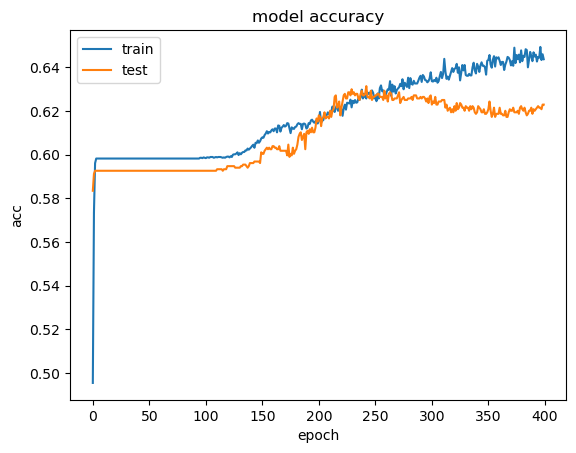

In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Summarizing history for loss For Convolutional Neural Networks

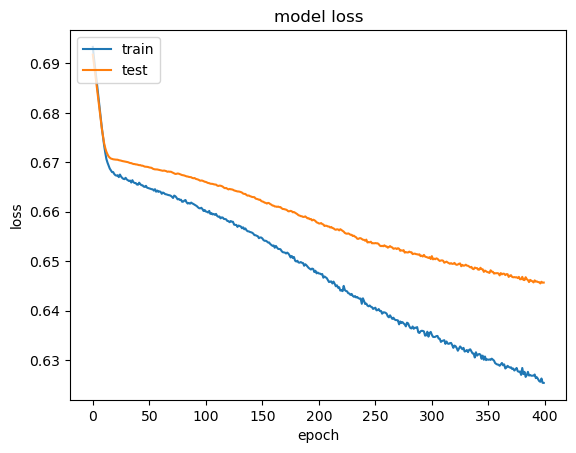

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
accuracy, loss = model.evaluate(X_test_2d, Y_test_norm)
print(f"Val accuracy={accuracy}  val loss={loss}")

45/45 [==============================] - 1s 10ms/step - loss: 0.6457 - acc: 0.6230
Val accuracy=0.6456776261329651  val loss=0.6229739189147949


In [27]:
y_predicted =  model.predict(X_test_2d)

confusion_mat = confusion_matrix(Y_test_norm, np.round(model.predict(X_test_2d)))
confusion_mat

45/45 [==============================] - 0s 7ms/step


array([[165, 413],
       [122, 719]])

In [28]:
print(
    "True Positive for schizophrenia ", confusion_mat[0, 0], "\n",
    "False Positive for schizophrenia ", confusion_mat[0, 1], "\n",
    "False Neagtive For Healthy ", confusion_mat[1, 0], "\n",
    "True Neagtive For Healthy ", confusion_mat[1, 1], "\n")

True Positive for schizophrenia  165 
 False Positive for schizophrenia  413 
 False Neagtive For Healthy  122 
 True Neagtive For Healthy  719 



In [29]:
TP = confusion_mat[0, 0]
FP = confusion_mat[0, 1]
FN = confusion_mat[1, 0]
TN = confusion_mat[1, 1]
TP, FP, FN, TN

(165, 413, 122, 719)

### Sensitivity for the first network
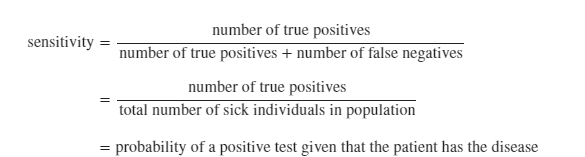

In [30]:
sensitivity = TP / (TP + FN)
sensitivity

0.5749128919860628

### Specificity for the first network
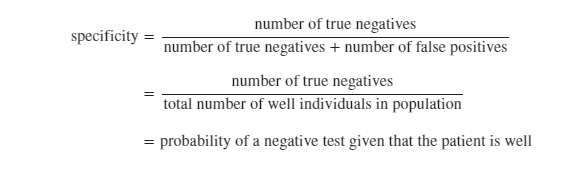

In [31]:
specificity = TN / (TN + FP)
specificity

0.6351590106007067

### Fully Connected Neural Network (Check 2 with tweeked parameters)

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

In [36]:
filepath="/kaggle/working/best_model2.h5" # Checkpoints
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# Simple Neural Networks with 5000 Neurons
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=(5, 20),
                 activation='tanh',
                 input_shape=(X_train_2d.shape[1:])))
model_2.add(MaxPooling2D(pool_size=(5, 15)))

model_2.add(Conv2D(128, kernel_size=(3, 3),
                 activation='tanh',))
model_2.add(MaxPooling2D(pool_size=(3, 3)))

model_2.add(Dropout(0.15))
model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.optimizers.Adam(0.000005),
              metrics=['acc'])

In [37]:
history_2 = model.fit(X_train_2d, Y_train_norm,
          batch_size=256,
          epochs=300,
          verbose=1,
          shuffle=True,
          validation_data=(X_test_2d, Y_test_norm), callbacks=[checkpoint])

Epoch 1/300
22/23 [===========================>..] - ETA: 0s - loss: 0.6261 - acc: 0.6470
Epoch 1: val_acc improved from -inf to 0.62156, saving model to /kaggle/working/best_model2.h5
23/23 [==============================] - 5s 218ms/step - loss: 0.6260 - acc: 0.6473 - val_loss: 0.6453 - val_acc: 0.6216
Epoch 2/300
22/23 [===========================>..] - ETA: 0s - loss: 0.6256 - acc: 0.6474
Epoch 2: val_acc improved from 0.62156 to 0.62227, saving model to /kaggle/working/best_model2.h5
23/23 [==============================] - 5s 212ms/step - loss: 0.6252 - acc: 0.6475 - val_loss: 0.6451 - val_acc: 0.6223
Epoch 3/300
22/23 [===========================>..] - ETA: 0s - loss: 0.6252 - acc: 0.6424
Epoch 3: val_acc did not improve from 0.62227
23/23 [==============================] - 5s 208ms/step - loss: 0.6254 - acc: 0.6418 - val_loss: 0.6458 - val_acc: 0.6195
Epoch 4/300
22/23 [===========================>..] - ETA: 0s - loss: 0.6247 - acc: 0.6516
Epoch 4: val_acc did not improve from 

In [38]:
loss, accuracy = model_2.evaluate(X_test_2d, Y_test_norm)
loss, accuracy 

45/45 [==============================] - 1s 10ms/step - loss: 0.6958 - acc: 0.4073


(0.6958438158035278, 0.40732911229133606)

### Summarizing History For Accuracy And Loss For Second Network

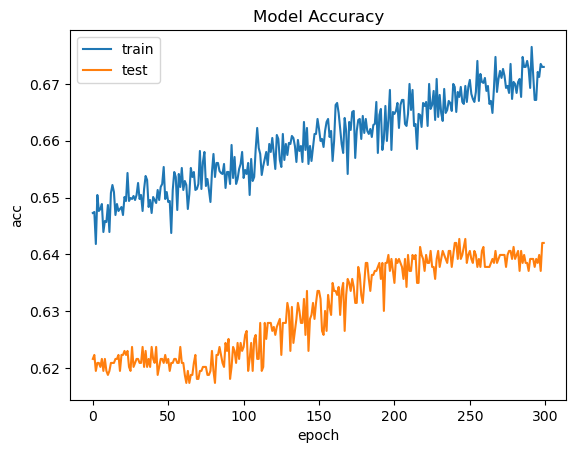

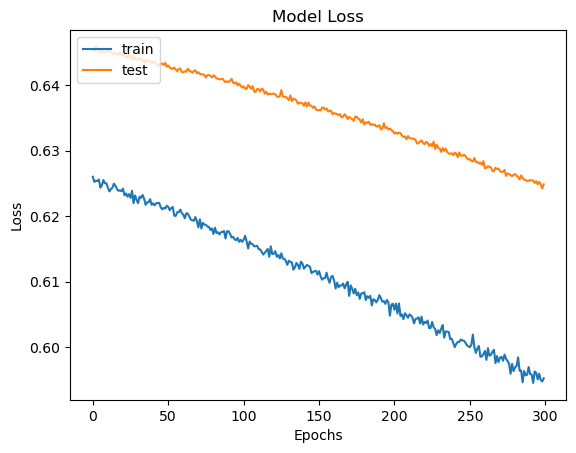

In [39]:
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Confusion matrix

In [40]:
y_predicted =  model_2.predict(X_test_2d)

confusion_mat = confusion_matrix(Y_test_norm, np.round(model_2.predict(X_test_2d)))
confusion_mat

45/45 [==============================] - 0s 7ms/step


array([[578,   0],
       [841,   0]])

In [42]:
print(
 "True Positive for schizophrenia ", confusion_mat[0, 0], "\n",
 "False Positive for schizophrenia ", confusion_mat[0, 1], "\n",
 "False Neagtive For Healthy ", confusion_mat[1, 0], "\n",
 "True Neagtive For Healthy ", confusion_mat[1, 1], "\n"    
)

True Positive for schizophrenia  578 
 False Positive for schizophrenia  0 
 False Neagtive For Healthy  841 
 True Neagtive For Healthy  0 



In [43]:
TP = confusion_mat[0, 0]
FP = confusion_mat[0, 1]
FN = confusion_mat[1, 0]
TN = confusion_mat[1, 1]
TP, FP, FN, TN

(578, 0, 841, 0)

### Sensitivity for the Second network
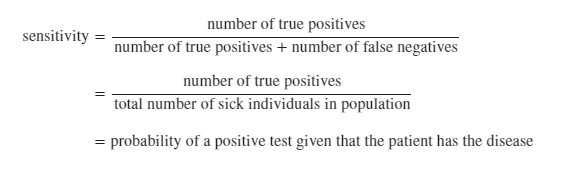

In [44]:
sensitivity = TP / (TP + FN)
print(sensitivity)

0.4073291050035236


### Specificity for the Second network
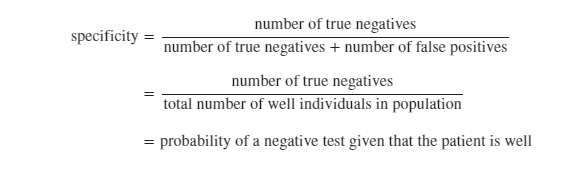

In [45]:
specificity = TN / (TN + FP)
print(specificity)

nan
